# Check GPU Availability

In [1]:
import torch
print(torch.__version__)
print("CUDA:", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.3.1+cu121
CUDA: True
NVIDIA GeForce RTX 3050 Laptop GPU


Load .env

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Converting pdf to document structure

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader
file_path = r'D:\Coding\Learning\LLMs\RAG\Data\Machine_learning.pdf'

loader = PyMuPDFLoader(file_path)
docs = loader.load()
print(len(docs))
print(docs[0].page_content[:200])


120
MACHINE LEARNING  
[R17A0534] 
LECTURE NOTES 
 
B.TECH IV YEAR – I SEM(R17) 
(2020-21) 
 
 
 
 
 
 
DEPARTMENT OF 
COMPUTER SCIENCE AND ENGINEERING 
MALLA REDDY COLLEGE OF ENGINEERING & 
TECHNOLOGY 
(


In [5]:
len(docs)

120

In [6]:
docs[1].page_content[:100]


'IV Year B. Tech. CSE –II Sem   \n \n \n \n \n \n                L   T/P/D   C  \n  4   1/- / -   3  \n(R17A0'

# Cleaning function

In [7]:
import re

def cleaning_text(text: str) -> str:
    if not text:
        return ""

    text = re.sub(r'\n+', '\n', text)     # collapse newlines
    text = re.sub(r'\s+', ' ', text)      # collapse spaces
    text = re.sub(r'Page \d+', '', text)  # remove page numbers
    text = text.strip()

    return text


# Cleaning and division of data

In [8]:
from langchain_core.documents import Document

# -----------------------------
# SETTINGS
# -----------------------------
MIN_TEXT_LENGTH = 40   # Ignore very tiny text fragments

# -----------------------------
# VARIABLES / CONTAINERS
# -----------------------------
final_documents = []       # This will hold page-level documents
page_text_buffer = ""      # Temporary text storage for current page
current_page_number = None # Track which page we are on

# Get file name from metadata safely
source_file = docs[0].metadata.get("source", "unknown.pdf") if docs else "unknown.pdf"

print(f"Processing {len(docs)} raw elements from: {source_file}")

# -----------------------------
# MAIN LOOP
# -----------------------------
for element in docs:

    # Clean text using your custom function
    cleaned_text = cleaning_text(element.page_content)

    # Skip very small text like headers, page numbers, etc.
    if len(cleaned_text) < MIN_TEXT_LENGTH:
        continue

    # Get page number safely
    page_number = element.metadata.get("page_number") or element.metadata.get("page", 1)

    # -------------------------
    # PAGE CHANGE DETECTION
    # -------------------------
    if current_page_number is not None and page_number != current_page_number:
        
        # Save previous page content
        final_documents.append(
            Document(
                page_content=page_text_buffer.strip(),
                metadata={
                    "source": source_file,
                    "page": current_page_number
                }
            )
        )

        # Start buffer for new page
        page_text_buffer = cleaned_text

    else:
        # Same page → keep adding text
        page_text_buffer += " " + cleaned_text

    # Update current page tracker
    current_page_number = page_number


# -----------------------------
# FINAL SAVE (LAST PAGE)
# -----------------------------
if page_text_buffer:
    final_documents.append(
        Document(
            page_content=page_text_buffer.strip(),
            metadata={
                "source": source_file,
                "page": current_page_number
            }
        )
    )

# -----------------------------
# VERIFICATION
# -----------------------------
print(f"\nMerged {len(docs)} fragments into {len(final_documents)} full pages.")

for doc in final_documents[:3]:
    print(f"\nPage {doc.metadata['page']}")
    print(doc.page_content[:200], "...")


Processing 120 raw elements from: D:\Coding\Learning\LLMs\RAG\Data\Machine_learning.pdf

Merged 120 fragments into 119 full pages.

Page 0
MACHINE LEARNING [R17A0534] LECTURE NOTES B.TECH IV YEAR – I SEM(R17) (2020-21) DEPARTMENT OF COMPUTER SCIENCE AND ENGINEERING MALLA REDDY COLLEGE OF ENGINEERING & TECHNOLOGY (Autonomous Institution – ...

Page 1
IV Year B. Tech. CSE –II Sem L T/P/D C 4 1/- / - 3 (R17A0534) Machine Learning Objectives:  Acquire theoretical Knowledge on setting hypothesis for pattern recognition.  Apply suitable machine learn ...

Page 2
TEXT BOOKS: 1. Ethem Alpaydin, ”Introduction to Machine Learning”, MIT Press, Prentice Hall of India, 3rd Edition2014. 2. Mehryar Mohri, Afshin Rostamizadeh, Ameet Talwalkar ” Foundations of Machine L ...


In [9]:
len(final_documents)

119

# Chunking of data

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# -----------------------------------
# TEXT SPLITTING CONFIGURATION
# -----------------------------------
# These values work well for technical books / PDFs
CHUNK_SIZE = 1200      # Max characters per chunk
CHUNK_OVERLAP = 200    # Shared context between chunks

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True  # Useful for debugging / tracing later
)

print("\nSplitting documents into RAG-friendly chunks...")

# -----------------------------------
# SPLITTING PROCESS
# -----------------------------------
rag_chunks = text_splitter.split_documents(final_documents)

# -----------------------------------
# VERIFICATION
# -----------------------------------
print(f"Original Page Documents: {len(final_documents)}")
print(f"Generated RAG Chunks: {len(rag_chunks)}")

# Preview first few chunks
for chunk in rag_chunks[:3]:
    print("\n--- Chunk Preview ---")
    print(chunk.page_content[:200], "...")
    print("Metadata:", chunk.metadata)



Splitting documents into RAG-friendly chunks...
Original Page Documents: 119
Generated RAG Chunks: 275

--- Chunk Preview ---
MACHINE LEARNING [R17A0534] LECTURE NOTES B.TECH IV YEAR – I SEM(R17) (2020-21) DEPARTMENT OF COMPUTER SCIENCE AND ENGINEERING MALLA REDDY COLLEGE OF ENGINEERING & TECHNOLOGY (Autonomous Institution – ...
Metadata: {'source': 'D:\\Coding\\Learning\\LLMs\\RAG\\Data\\Machine_learning.pdf', 'page': 0, 'start_index': 0}

--- Chunk Preview ---
IV Year B. Tech. CSE –II Sem L T/P/D C 4 1/- / - 3 (R17A0534) Machine Learning Objectives:  Acquire theoretical Knowledge on setting hypothesis for pattern recognition.  Apply suitable machine learn ...
Metadata: {'source': 'D:\\Coding\\Learning\\LLMs\\RAG\\Data\\Machine_learning.pdf', 'page': 1, 'start_index': 0}

--- Chunk Preview ---
Functions, K Nearest Neighbors. Introduction to clustering, K-means clustering, K-Mode Clustering. UNIT III: Ensemble and Probabilistic Learning Model Combination Schemes, Voting, Error-Corre

In [11]:
print(rag_chunks[1])

page_content='IV Year B. Tech. CSE –II Sem L T/P/D C 4 1/- / - 3 (R17A0534) Machine Learning Objectives:  Acquire theoretical Knowledge on setting hypothesis for pattern recognition.  Apply suitable machine learning techniques for data handling and to gain knowledge from it.  Evaluate the performance of algorithms and to provide solution for various real world applications. UNIT I: Introduction to Machine Learning Introduction ,Components of Learning , Learning Models , Geometric Models, Probabilistic Models, Logic Models, Grouping and Grading, Designing a Learning System, Types of Learning, Supervised, Unsupervised, Reinforcement, Perspectives and Issues, Version Spaces, PAC Learning, VC Dimension. UNIT II: Supervised and Unsupervised Learning Decision Trees: ID3, Classification and Regression Trees, Regression: Linear Regression, Multiple Linear Regression, Logistic Regression, Neural Networks: Introduction, Perception, Multilayer Perception, Support Vector Machines: Linear and No

In [12]:
len(rag_chunks[0].page_content)

480

# Loading the embedding model - all-MiniLM-L6-v2

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings
import torch

# -------------------------------
# STEP 1: EMBEDDING MODEL
# -------------------------------
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"   # 384 dimensions
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

embeddings = HuggingFaceEmbeddings(
    model_name=MODEL_NAME,
    model_kwargs={"device": DEVICE},
    encode_kwargs={"normalize_embeddings": False}
)

print("Embedding model loaded successfully!")


Using device: cuda


d:\Coding\Learning\LLMs\RAG\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model loaded successfully!


# Building the faiss database and storing the chunks

In [16]:
from langchain_community.vectorstores import FAISS
from pathlib import Path

# -----------------------------------
# STEP 2: BUILD FAISS DATABASE
# -----------------------------------

FAISS_PATH = r"D:\Coding\Learning\LLMs\RAG\faiss_db"

print("\nBuilding FAISS Vector Database...")

# Create FAISS DB from documents
vector_db = FAISS.from_documents(
    documents=rag_chunks,
    embedding=embeddings
)

# Save DB locally
vector_db.save_local(FAISS_PATH)

print("FAISS DB Built Successfully!")
print(f"Saved at: {FAISS_PATH}")
print(f"Total Chunks Stored: {len(rag_chunks)}")



Building FAISS Vector Database...


d:\Coding\Learning\LLMs\RAG\.venv\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


FAISS DB Built Successfully!
Saved at: D:\Coding\Learning\LLMs\RAG\faiss_db
Total Chunks Stored: 275


# Loading faiss

In [17]:
from langchain_community.vectorstores import FAISS

# -----------------------------------
# STEP 3: LOAD EXISTING FAISS DB
# -----------------------------------

FAISS_PATH = r"D:\Coding\Learning\LLMs\RAG\faiss_db"

print("\nLoading FAISS Database...")

vector_db = FAISS.load_local(
    FAISS_PATH,
    embeddings,
    allow_dangerous_deserialization=True   # required
)

print("FAISS Loaded Successfully!")



Loading FAISS Database...
FAISS Loaded Successfully!


# Testing a query via cosine similarity search

In [21]:
query = "what are neural networks?"

results = vector_db.similarity_search(query, k=3)

for i, doc in enumerate(results, 1):
    print(f"\nResult {i}")
    print(doc.page_content[:300])
    print(doc.metadata)


Result 1
the cons of ANN networks, which are a flourishing science branch, are eliminated individually, and their pros are increasing day by day. It means that artificial neural networks will turn into an irreplaceable part of our lives progressively important.” How do artificial neural networks work? Artifi
{'source': 'D:\\Coding\\Learning\\LLMs\\RAG\\Data\\Machine_learning.pdf', 'page': 47, 'start_index': 2004}

Result 2
performs tasks. The majority of the artificial neural networks will have some similarities with a more complex biological partner and are very effective at their expected tasks. For example, segmentation or classification. Feedback ANN: In this type of ANN, the output returns into the network to acc
{'source': 'D:\\Coding\\Learning\\LLMs\\RAG\\Data\\Machine_learning.pdf', 'page': 48, 'start_index': 2011}

Result 3
not provide insight concerning why and how. It decreases trust in the network. Hardware dependence: Artificial neural networks need processors with parall

# Imports for LangGraph framework & workflow

In [70]:
import os
from typing import Annotated, Literal, TypedDict, List
from pydantic import BaseModel, Field

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# LangChain Core
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate

# Models
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq


# Schema

In [71]:
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "llm_chat"]

# Shared Mem

In [72]:
class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    route_decision: str

# Initialize Models

In [87]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
router_llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0,
)
responder_llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

# Nodes

In [102]:
def router_node(state: GraphState):
    last_message = state["messages"][-1].content

    prompt = ChatPromptTemplate.from_messages([
        ("system", """
You are a STRICT routing engine, not a chatbot.

Your ONLY job is to choose ONE word from the allowed options.

ALLOWED OUTPUTS:
vectorstore
llm_chat

RULES:
- Output ONLY one word
- No punctuation
- No explanations
- No extra text
- No formatting
- Do NOT repeat the question
- Do NOT say both options
- If unsure → llm_chat

DECISION LOGIC:
- vectorstore → ML concepts, algorithms, formulas, technical definitions
- llm_chat → greetings, jokes, opinions, casual talk
"""),
        ("human", "{question}")
    ])

    chain = prompt | router_llm
    response = chain.invoke({"question": last_message})

    raw_output = response.content.strip().lower()

    print("\n--- ROUTER RAW OUTPUT ---")
    print(raw_output)

    # Strong normalization
    if raw_output.startswith("vector"):
        decision = "vectorstore"
    elif raw_output.startswith("llm"):
        decision = "llm_chat"
    else:
        decision = "llm_chat"  # fail-safe

    print(f"--- ROUTER DECISION --- {decision}")

    return {"route_decision": decision}


# Faiss Node

In [103]:
def vectorstore_node(state: GraphState):
    print("\n--- [NODE] RAG: RETRIEVING FROM PDF ---")

    question = state["messages"][-1].content
    print("User Question:", question)

    # -----------------------------------
    # RETRIEVE
    # -----------------------------------
    docs = vector_db.similarity_search(question, k=3)

    if not docs:
        print("No documents retrieved")
        response = responder_llm.invoke(question)
        return {"messages": [response]}

    # -----------------------------------
    # SHOW CONTEXT
    # -----------------------------------
    print("\n--- RETRIEVED CONTEXT ---")
    context_parts = []

    for i, d in enumerate(docs, 1):
        snippet = d.page_content[:400].replace("\n", " ")

        print(f"\n[Chunk {i}]")
        print(snippet)
        print("Metadata:", d.metadata)

        context_parts.append(d.page_content)

    context = "\n\n".join(context_parts)

    # -----------------------------------
    # PROMPT
    # -----------------------------------
    rag_prompt = f"""
You are a Machine Learning assistant.

Use ONLY the provided context to answer the question.
If context is insufficient, say "Context not sufficient."

CONTEXT:
{context}

QUESTION:
{question}
"""

    # -----------------------------------
    # RESPONSE
    # -----------------------------------
    response = responder_llm.invoke(rag_prompt)

    print("\n--- FINAL ANSWER ---")
    print(response.content)

    return {"messages": [response]}


## Chat & Conditional node

In [104]:
def llm_chat_node(state: GraphState):
    response = responder_llm.invoke(state["messages"])
    return {"messages": [response]}
def decide_next_node(state: GraphState):
    decision = state["route_decision"]

    if decision == "vectorstore":
        return "vectorstore"

    return "llm_chat"


# Build graph and compile

In [105]:
workflow = StateGraph(GraphState)

workflow.add_node("router", router_node)
workflow.add_node("vectorstore", vectorstore_node)
workflow.add_node("llm_chat", llm_chat_node)

workflow.add_edge(START, "router")

workflow.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "vectorstore": "vectorstore",
        "llm_chat": "llm_chat"
    }
)

workflow.add_edge("vectorstore", END)
workflow.add_edge("llm_chat", END)

app = workflow.compile()


# Visualize the graph

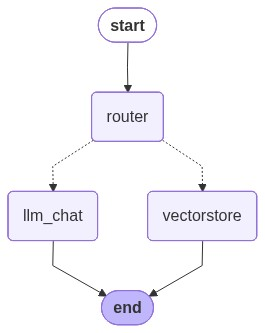

In [106]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [110]:
result = app.invoke({
    "messages": [HumanMessage(content="What are KD-trees.")]
})

print(result["messages"][-1].content)


--- ROUTER RAW OUTPUT ---
vectorstore
--- ROUTER DECISION --- vectorstore

--- [NODE] RAG: RETRIEVING FROM PDF ---
User Question: What are KD-trees.

--- RETRIEVED CONTEXT ---

[Chunk 1]
very simple. You create a binary tree by choosing one dimension at a time to split into two, and placing the line through the median of the point coordinates of that dimension. The points themselves end up as leaves of the tree. Making the tree follows pretty much the same steps as usual for constructing a binary tree: we identify a place to split into two choices, left and right, and then carry o
Metadata: {'source': 'D:\\Coding\\Learning\\LLMs\\RAG\\Data\\Machine_learning.pdf', 'page': 84, 'start_index': 1002}

[Chunk 2]
82 FIGURE 8: The splits and leaf points found by the KD-tree. FIGURE 9: The KD-tree that made the splits. Searching the tree is the same as any other binary tree; we are more interested in finding the nearest neighbours of a test point. This is fairly easy: starting at the root of t